Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: Policy Search

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The player **taking the last object wins**.

* Task3.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task3.2: An agent using evolved rules
* Task3.3: An agent using minmax
* Task3.4: An agent using reinforcement learning

## Instructions

* Create the directory `lab3` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.

## Deadlines ([AoE](https://en.wikipedia.org/wiki/Anywhere_on_Earth)) 

* Sunday, December 4th for Task3.1 and Task3.2
* Sunday, December 11th for Task3.3 and Task3.4
* Sunday, December 18th for all reviews

## Solution

In [15]:
import logging
import random
from collections import namedtuple
from itertools import accumulate
from operator import xor
from copy import deepcopy
from typing import Callable
import math

In [16]:
logging.basicConfig(level=logging.INFO)

In [17]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [207]:
class Nim():
    '''a basic class for the game of Nim'''
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i*2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    def nimming(self, row: int, num_objects: int) -> None:
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
        #if sum(self._rows) == 0:
            #logging.info("Yeuch")

    def nimming2(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
            
    def is_terminal(self) -> bool:
        return sum(self._rows) == 0
        
    def utility(self):
        return 1 if self.is_terminal() else 0  

    def actions(self, k = None):
        if k is None:        
            return [(i, j) for i in range(len(self._rows)) for j in range(1, self._rows[i] + 1)]
        else:
            return [(i, j) for i in range(len(self._rows)) for j in range(1, min(self._rows[i] + 1, k + 1))]   

In [21]:
def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

In [248]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result

### Task 3.1: An agent using fixed rules based

In [28]:
num_rows = 5
k = 3
z = Nim(num_rows, k)
z._rows

[1, 3, 5, 7, 9]

In [37]:
def rules(z, num_rows):
    '''a very basic AI based on simple rules'''
    cont1 = 0   # number of rows with 1 object
    cont0 = 0   # number of rows with 0 objects
    contN = 0   # number of rows with more than 1 object
    for i in range(len(z._rows)):
        if z._rows[i] == 1:
            cont1 += 1
        elif z._rows[i] == 0:
            cont0 += 1
        else:
            contN += 1
    
    # if there are more 1's and 0's then other numbers 
    if cont1 + cont0 >= num_rows//2:
        if cont1 % 2 == 0 and contN == 1:
            # then the AI will try to remove the highest number 
            move = max(z.actions(k), key = lambda x: x[1])
            z.nimming(move[0], move[1])
        elif cont1 % 2 != 0 and contN == 1: 
            # then the AI will try to remove the highest number - 1 (if possible)
            move_ = max(z.actions(k), key = lambda x: x[1])
            move = (move_[0], move_[1] - 1 if move_[1] > 1 else move_[1])
            z.nimming(move[0], move[1])
        else:
            # otherwise the AI will remove a random number
            move = random.choice(z.actions(k))
            z.nimming(move[0], move[1])
    # else the AI will move randomly
    else:        
        move = random.choice(z.actions(k))
        z.nimming(move[0], move[1])

    return move

In [38]:
my_turn = not random.choice([True,False])

In the next cell you have an interactive Nim game with a rule based agent. When you play it, and it is your turn, you need to input the row (zero based) first and the number of objects secondly.

In [39]:
# Play the game
while not z.is_terminal():
    my_turn = not my_turn
    if my_turn:      
        input_validation = False
        while input_validation is not True:
            try:
                pre = z._rows.copy()
                row = input(f"Your turn! Situation:{z._rows} Row (zero based): ")
                num_objects = input(f"Situation:{z._rows} k is {k} Number of objects: ")
                assert row != '' and num_objects != '' 
                assert int(row) in range(len(z._rows))
                assert int(num_objects) <= k if k is not None else True
                assert int(num_objects) in range(1, z._rows[int(row)] + 1)
                z.nimming(int(row), int(num_objects))
                input_validation = True
                logging.info(f"Situation pre my_turn:{pre} post my_turn:{z._rows} move:({row}, {num_objects})")
            except AssertionError:
                print("Invalid move")
    else:
        logging.info(f"Possible pc actions for this turn: \n{z.actions(k)}")
        pre = z._rows.copy()
        move = rules(z, len(z._rows))
        logging.info(f"Situation pre pc_turn:{pre} post pc_turn:{z._rows} move: {move}")

if my_turn:
    print("You won!")
else:
    print("You lost!")

INFO:root:Situation pre my_turn:[1, 3, 5, 7, 9] post my_turn:[1, 3, 5, 7, 6] move:(4, 3)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3)]
INFO:root:Situation pre pc_turn:[1, 3, 5, 7, 6] post pc_turn:[1, 3, 5, 7, 5] move: (4, 1)
INFO:root:Situation pre my_turn:[1, 3, 5, 7, 5] post my_turn:[1, 3, 5, 7, 2] move:(4, 3)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2)]
INFO:root:Situation pre pc_turn:[1, 3, 5, 7, 2] post pc_turn:[1, 0, 5, 7, 2] move: (1, 3)


Invalid move
Invalid move


INFO:root:Situation pre my_turn:[1, 0, 5, 7, 2] post my_turn:[1, 0, 5, 7, 0] move:(4, 2)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
INFO:root:Situation pre pc_turn:[1, 0, 5, 7, 0] post pc_turn:[1, 0, 5, 6, 0] move: (3, 1)
INFO:root:Situation pre my_turn:[1, 0, 5, 6, 0] post my_turn:[1, 0, 5, 3, 0] move:(3, 3)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
INFO:root:Situation pre pc_turn:[1, 0, 5, 3, 0] post pc_turn:[1, 0, 2, 3, 0] move: (2, 3)
INFO:root:Situation pre my_turn:[1, 0, 2, 3, 0] post my_turn:[1, 0, 2, 0, 0] move:(3, 3)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (2, 1), (2, 2)]
INFO:root:Situation pre pc_turn:[1, 0, 2, 0, 0] post pc_turn:[1, 0, 1, 0, 0] move: (2, 1)
INFO:root:Situation pre my_turn:[1, 0, 1, 0, 0] post my_turn:[1, 0, 0, 0, 0] move:(2, 1)
INFO:root:Possible pc actions for this turn: 
[(0, 1)]
INFO:root:Yeuch
INFO:root:Situation pre pc

You lost!


### Task 3.2: An agent using evolved rules

In [139]:
def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["nim_sum"] = nim_sum(state)   

    # Mine
    # I take track of several statistics
    cont1 = 0   # number of rows with 1 object
    cont0 = 0   # number of rows with 0 objects
    contN = 0   # number of rows with more than 1 object
    for i in range(len(z._rows)):
        if z._rows[i] == 1:
            cont1 += 1
        elif z._rows[i] == 0:
            cont0 += 1
        else:
            contN += 1

    cooked['cont1'] = cont1
    cooked['cont0'] = cont0
    cooked['contN'] = contN
    cooked['num_rows'] = len(z._rows)
    cooked['cont1%2!=0'] = cont1 % 2 != 0
    cooked['contN==1'] = contN == 1
    cooked['cont1%2==0'] = cont1 % 2 == 0
    cooked['cont1 + cont0'] = cont1 + cont0

    # end Mine

    brute_force = list()
    for m in cooked["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming2(m)
        brute_force.append((m, nim_sum(tmp)))
    cooked["brute_force"] = brute_force

    return cooked

In [252]:
def optimal_startegy(state: Nim) -> Nimply:
    '''optimal strategy for Nim'''
    data = cook_status(state)
    return next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]

In [32]:
def make_strategy(genome: dict) -> Callable:
    def evolvable(state: Nim) -> Nimply:
        data = cook_status(state)

        if data['cont1 + cont0'] * genome['a'] >= num_rows * genome['b']:
            if data['cont1%2==0'] and data['contN'] == genome['c']:
                # then the AI will try to remove the highest number 
                move = max(data['possible_moves'], key = lambda x: x[1])
            elif data['cont1%2!=0'] and data['contN'] == genome['c']: 
                # then the AI will try to remove the highest number - 1 (if possible)
                move_ = max(data['possible_moves'], key = lambda x: x[1])
                move = (move_[0], move_[1] - 1 if move_[1] > 1 else move_[1])
            else:
                # otherwise the AI will remove a random number
                move = random.choice(data['possible_moves'])
        # else the AI will move randomly
        else:        
            move = random.choice(data['possible_moves'])

        return move #ply

    return evolvable

In [146]:
NUM_MATCHES = 20
NIM_SIZE = 10


def evaluate(strategy: Callable, opponent_) -> float:
    '''evaluate the strategy against the opponent'''
    opponents = (strategy, opponent_)
    won = 0

    for m in range(NUM_MATCHES):
        nim = Nim(NIM_SIZE)
        player = 0
        while nim:
            ply = opponents[player](nim)
            nim.nimming2(ply)
            player = 1 - player
        if player == 1:
            won += 1
    return won / NUM_MATCHES

In [85]:
# As we can see, the optimal strategy is unbeatable against a random strategy
print(f"Pure random vs optimal strategy: {evaluate(pure_random, optimal_startegy)}%")

Pure random vs optimal strategy: 0.0%


In [121]:
# My rule based strategy is barely better than the random one
evaluate(make_strategy({'a': 1, 'b': 0.5, 'c': 1}), pure_random)

0.65

So the idea is to parameterise the conditions (rules) inside my rule based agent and then use a GA algorithm to find the optimal parameters

In [110]:
Individual = namedtuple("Individual", ["genome", "fitness"])

In [90]:
def fitness(genome, k = None):
    '''Fitness function'''
    return evaluate(make_strategy({'a': genome[0], 'b': genome[1], 'c': genome[2]}), pure_random)

def tournament_with_a_hole(population, tournament_size = 2):
    '''Tournament selection with fitness hole'''
    if random.random() < 0.3:
        return max(random.choices(population, k = tournament_size), key= lambda i: math.fsum(i.genome))
    else:
        return max(random.choices(population, k = tournament_size), key= lambda i: i.fitness)

def mutation_rate(g):
    '''Mutation rate function'''
    return 1 - g  # more exploration in early generations, more exploitation in later ones

def cross_over(g1, g2):
    '''Cross-Over function'''
    # The idea is to create a new genoma that is made by parts (lists) of the parents' genomes
    cut = random.randint(0, 3 - 1)
    logging.debug(f"Cut: {cut}")
    return list(list(g1[:cut]) + list(g2[cut:]))    


def mutation(g, search_space):
    '''Mutation function'''
    # The idea is to sobstitute one gene (a list) with an other from the initial (problem) list (Allele)
    point = random.randint(0, 3 - 1)
    g = list(g)
    g[point] = random.choice(search_space)[point]
    return g  

In [54]:
# inzialization of the population, search space and parameters
offspring_size = 20
population_size = 100
num_generations = 100

population = list()
search_space = list()

for a in [0.1,0.3,0.5,0.7,0.9,1,1.1,1.3,1.5,1.7,1.9,2]:
    for b in [0.1,0.3,0.5,0.7,0.9,1,1.1,1.3,1.5,1.7,1.9,2]:
        for c in [0.1,0.3,0.5,0.7,0.9,1,1.1,1.3,1.5,1.7,1.9,2]:
            genome = [a,b,c]
            search_space.append(genome)
            population.append(Individual(genome, fitness(genome, 0)))

In [55]:
population.sort(key = lambda i: i.fitness, reverse = True)

In [56]:
len(population)

1728

In [ ]:
# Let's start the evolution!!!
for g in range(num_generations):
    for i in range(offspring_size):
        if random.random() < mutation_rate(population[0].fitness):
            p = tournament_with_a_hole(population, 20)
            o = mutation(p.genome, search_space)
        else:        
            p1 = tournament_with_a_hole(population, 20)
            p2 = tournament_with_a_hole(population, 20)
            logging.debug(f"p1: {p1}, p2: {p2}")
            o = cross_over(p1.genome, p2.genome)
            logging.debug(f"o: {o}")
        
        f = fitness(o)
        population.append(Individual(o, f))
    
    population.sort(key = lambda i: i.fitness, reverse = True)
    population = population[:population_size]

print(f"Best genome: {population[0].genome}")
print(f"Best fitness: {population[0].fitness}")    


In [104]:
# The Best genome is [1.5, 0.3, 0.1] and the best fitness is 0.95.
best_genome = population[0].genome
best_genome

[1.5, 0.3, 0.1]

In [108]:
# the result is improved, but not enough to beat the optimal strategy
make_strategy({'a': best_genome[0], 'b': best_genome[1], 'c': best_genome[2]}, pure_random)

0.8

If you would like to play a game against it...

In [141]:
num_rows = 5
k = None
z = Nim(num_rows)
z._rows

[1, 3, 5, 7, 9]

In [142]:
my_turn = not random.choice([True,False])

In [143]:
# Play the game
while not z.is_terminal():
    my_turn = not my_turn
    if my_turn:      
        input_validation = False
        while input_validation is not True:
            try:
                pre = z._rows.copy()
                row = input(f"Your turn! Situation:{z._rows} Row (zero based): ")
                num_objects = input(f"Situation:{z._rows} k is {k} Number of objects: ")
                assert row != '' and num_objects != ''
                assert int(row) in range(len(z._rows))
                assert int(num_objects) <= k if k is not None else True
                assert int(num_objects) in range(1, z._rows[int(row)] + 1)
                z.nimming(int(row), int(num_objects))
                input_validation = True
                logging.info(f"Situation pre my_turn:{pre} post my_turn: {z._rows} move:({row}, {num_objects})")
            except AssertionError:
                print("Invalid move")
    else:
        logging.info(f"Possible pc actions for this turn: \n{z.actions(k)}")
        pre = z._rows.copy()
        move = make_strategy({'a': best_genome[0], 'b': best_genome[1], 'c': best_genome[2]})(z)
        
        z.nimming2(move)
        logging.info(f"Situation pre pc_turn:{pre} post pc_turn:{z._rows} move: {move}")

if my_turn:
    print("You won!")
else:
    print("You lost!")

INFO:root:Situation pre my_turn:[1, 3, 5, 7, 9] post my_turn: [1, 3, 5, 7, 0] move:(4, 9)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7)]
INFO:root:Situation pre pc_turn:[1, 3, 5, 7, 0] post pc_turn:[1, 3, 4, 7, 0] move: (2, 1)
INFO:root:Situation pre my_turn:[1, 3, 4, 7, 0] post my_turn: [1, 3, 4, 0, 0] move:(3, 7)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (2, 4)]
INFO:root:Situation pre pc_turn:[1, 3, 4, 0, 0] post pc_turn:[1, 0, 4, 0, 0] move: (1, 3)


Invalid move


INFO:root:Situation pre my_turn:[1, 0, 4, 0, 0] post my_turn: [1, 0, 2, 0, 0] move:(2, 2)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (2, 1), (2, 2)]
INFO:root:Situation pre pc_turn:[1, 0, 2, 0, 0] post pc_turn:[1, 0, 1, 0, 0] move: (2, 1)
INFO:root:Situation pre my_turn:[1, 0, 1, 0, 0] post my_turn: [0, 0, 1, 0, 0] move:(0, 1)
INFO:root:Possible pc actions for this turn: 
[(2, 1)]
INFO:root:Situation pre pc_turn:[0, 0, 1, 0, 0] post pc_turn:[0, 0, 0, 0, 0] move: (2, 1)


You lost!


I let it win ;)

### Task 3.3 (a): An agent using minmax (Vanilla)

In [14]:
def minmax(state, max_turn):
    '''minmax algorithm'''
    utils_ = utility(state, max_turn)
    if utils_ is not None:
        return utils_

    possible_new_states_list = possible_new_states(state, k)

    if max_turn:
        return max(minmax(new_state, max_turn=False) for new_state in possible_new_states_list)
    else:
        return min(minmax(new_state, max_turn=True) for new_state in possible_new_states_list)

def is_terminal(state):
    '''check if the state is terminal'''
    return sum(state) == 0

def utility(state, max_turn):
    '''returns the utility of a state'''
    if is_terminal(state):
        return 1 if not max_turn else -1

def possible_new_states(state, k):
    '''returns a list of possible new states'''
    if k == None:
        # if k is not defined, then the player can remove any number of objects from any row
        for row, objects in enumerate(state):            
            for remaining in range(objects):
                yield state[:row] + [remaining,] + state[row + 1 :]
    else:
        # if k is defined, then the player can remove any number of objects up to k from any row
        for row, objects in enumerate(state):            
            for remain in range(objects):
                if objects - remain <= k:
                    yield state[:row] + [remain,] + state[row + 1 :]

def minmax_bestmove(state):
    '''select the best move'''
    for new_state in possible_new_states(state, k):
        score = minmax(new_state, False)
        if score > 0:
            break
    
    for _, el in enumerate(state):
        if abs(state[_] - new_state[_]) > 0:
            logging.debug(f"({_},{state[_] - new_state[_]})")
            return (_ , state[_] - new_state[_])

Note: since the vanilla version is quite slow, I suggest you to test it with num_rows=3

In [18]:
num_rows = 3
k = 3
z = Nim(num_rows, k)
z._rows

[1, 3, 5]

In [19]:
my_turn = not random.choice([True,False])

In [20]:
# Play the game
while not z.is_terminal():
    my_turn = not my_turn
    if my_turn:      
        input_validation = False
        while input_validation is not True:
            try:
                pre = z._rows.copy()
                row = input(f"Your turn! Situation:{z._rows} Row (zero based): ")
                num_objects = input(f"Situation:{z._rows} k is {k} Number of objects: ")
                assert row != '' and num_objects != ''
                assert int(row) in range(len(z._rows))
                assert int(num_objects) <= k if k is not None else True
                assert int(num_objects) in range(1, z._rows[int(row)] + 1)
                z.nimming(int(row), int(num_objects))
                input_validation = True
                logging.info(f"Situation pre my_turn:{pre} post my_turn: {z._rows} move:({row}, {num_objects})")
            except AssertionError:
                print("Invalid move")
    else:
        logging.info(f"Possible pc actions for this turn: \n{z.actions(k)}")
        pre = z._rows.copy()
        move = minmax_bestmove(z._rows)
        z.nimming(move[0], move[1])
        logging.info(f"Situation pre pc_turn:{pre} post pc_turn:{z._rows} move: {move}")

if my_turn:
    print("You won!")
else:
    print("You lost!")

INFO:root:Situation pre my_turn:[1, 3, 5] post my_turn: [1, 1, 5] move:(1, 2)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (1, 1), (2, 1), (2, 2), (2, 3)]
INFO:root:Situation pre pc_turn:[1, 1, 5] post pc_turn:[0, 1, 5] move: (0, 1)
INFO:root:Situation pre my_turn:[0, 1, 5] post my_turn: [0, 1, 4] move:(2, 1)
INFO:root:Possible pc actions for this turn: 
[(1, 1), (2, 1), (2, 2), (2, 3)]
INFO:root:Situation pre pc_turn:[0, 1, 4] post pc_turn:[0, 0, 4] move: (1, 1)
INFO:root:Situation pre my_turn:[0, 0, 4] post my_turn: [0, 0, 2] move:(2, 2)
INFO:root:Possible pc actions for this turn: 
[(2, 1), (2, 2)]
INFO:root:Yeuch
INFO:root:Situation pre pc_turn:[0, 0, 2] post pc_turn:[0, 0, 0] move: (2, 2)


You lost!


### Task 3.3 (b): An agent using minmax (Alpha-Beta Pruning)

In [21]:
def alphabeta_minmax(state, max_turn, alpha = -1, beta = 1):
    '''minmax algorithm with alpha beta pruning'''
    utils_ = utility(state, max_turn)
    if utils_ is not None:
        return utils_

    possible_new_states_list = possible_new_states(state, k)

    child_scores = []
    for new_state in possible_new_states_list:
        score = alphabeta_minmax(new_state, max_turn = not max_turn, alpha=alpha, beta=beta)
        child_scores.append(score)

        if max_turn:
            alpha = max(alpha, score)
        else:
            beta = min(beta, score)
        # if beta is ever smaller than or equal to alpha, then the it can stop exploring that branch
        if beta <= alpha:
            break

    if max_turn:
        return max(child_scores)
    else:
        return min(child_scores)

def is_terminal(state):
    '''check if the state is terminal'''
    return sum(state) == 0

def utility(state, max_turn):
    '''returns the utility of a state'''
    if is_terminal(state):
        return 1 if not max_turn else -1

def possible_new_states(state, k):
    '''returns a list of possible new states''' 
    if k == None:
        # if k is not defined, then the player can remove any number of objects from any row
        for row, objects in enumerate(state):            
            for remaining in range(objects):
                yield state[:row] + [remaining,] + state[row + 1 :]
    else:
        # if k is defined, then the player can remove any number of objects up to k from any row
        for row, objects in enumerate(state):            
            for remain in range(objects):
                if objects - remain <= k:
                    yield state[:row] + [remain,] + state[row + 1 :]

def alphabeta_bestmove(state):
    '''select the best move'''
    for new_state in possible_new_states(state, k):
        score = alphabeta_minmax(new_state, False)
        if score > 0:
            break
    
    for _, el in enumerate(state):
        if abs(state[_] - new_state[_]) > 0:
            logging.debug(f"({_},{state[_] - new_state[_]})")
            return (_ , state[_] - new_state[_])

In [22]:
num_rows = 5
k = 3
z = Nim(num_rows, k)
z._rows

[1, 3, 5, 7, 9]

In [23]:
my_turn = not random.choice([True,False])

In [25]:
# Play the game
while not z.is_terminal():
    my_turn = not my_turn
    if my_turn:      
        input_validation = False
        while input_validation is not True:
            try:
                pre = z._rows.copy()
                row = input(f"Your turn! Situation:{z._rows} Row (zero based): ")
                num_objects = input(f"Situation:{z._rows} k is {k} Number of objects: ")
                assert row != '' and num_objects != ''
                assert int(row) in range(len(z._rows))
                assert int(num_objects) <= k if k is not None else True
                assert int(num_objects) in range(1, z._rows[int(row)] + 1)
                z.nimming(int(row), int(num_objects))
                input_validation = True
                logging.info(f"Situation pre my_turn:{pre} post my_turn:{z._rows} move:v({row}, {num_objects})")
            except AssertionError:
                print("Invalid move")
    else:
        logging.info(f"Possible pc actions for this turn: \n{z.actions(k)}")
        pre = z._rows.copy()
        move = alphabeta_bestmove(z._rows)
        z.nimming(move[0], move[1])
        logging.info(f"Situation pre pc_turn:{pre} post pc_turn:{z._rows} move: {move}")

if my_turn:
    print("You won!")
else:
    print("You lost!")

Invalid move


INFO:root:Situation pre my_turn:[1, 3, 5, 7, 9] post my_turn:[1, 3, 5, 7, 6] move:v(4, 3)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3)]
INFO:root:Situation pre pc_turn:[1, 3, 5, 7, 6] post pc_turn:[1, 1, 5, 7, 6] move: (1, 2)
INFO:root:Situation pre my_turn:[1, 1, 5, 7, 6] post my_turn:[1, 1, 5, 4, 6] move:v(3, 3)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3)]
INFO:root:Situation pre pc_turn:[1, 1, 5, 4, 6] post pc_turn:[1, 1, 2, 4, 6] move: (2, 3)
INFO:root:Situation pre my_turn:[1, 1, 2, 4, 6] post my_turn:[1, 1, 2, 1, 6] move:v(3, 3)
INFO:root:Possible pc actions for this turn: 
[(0, 1), (1, 1), (2, 1), (2, 2), (3, 1), (4, 1), (4, 2), (4, 3)]
INFO:root:Situation pre pc_turn:[1, 1, 2, 1, 6] post pc_turn:[0, 1, 2, 1, 6] move: (0, 1)
INFO:root:Situation pre my_turn:[0, 1, 2, 1, 6] post my_turn:[0

You lost!


### Task 3.4: An agent using reinforcement learning

In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
logging.basicConfig(level=logging.DEBUG)

In [311]:
class QLearner():
    q = {}
    previous_state = None
    previous_action = None
    win_REWARD = 100
    loss_REWARD = -100

    def __init__(self, state, k = None, epsilon = 0.98, learning_rate = 1, discount_factor = 1) -> None:        
        self.epsilon = epsilon                      # epsilon
        self.learning_rate = learning_rate          # alpha
        self.discount_factor = discount_factor      # gamma      
        

    def makeKey(self, state, k):
        possible_actions = list(self.possible_actions(state, k))
        an_action = possible_actions[0]
        logging.debug(f"state: {state} possible_actions: {possible_actions} an_action: {an_action}")
        # creating a Q Table
        if (tuple(state), an_action) not in self.q:
            for i in possible_actions:
                self.q[(tuple(state),i)] = np.random.uniform(0.0,0.01)

    def is_terminal(self, state):
        '''returns True if the state is terminal'''
        return sum(state) == 0

    def possible_actions(self, state, k):
        '''returns a list of possible actions for a given state'''
        if self.is_terminal(state):
            return [None]

        listo = []
        if k == None:
            # if k is not defined, then the player can remove any number of objects from any row
            
            for row, objects in enumerate(state):            
                for remaining in range(objects):
                    listo.append((row,objects - remaining))
            return listo
        else:
            # if k is defined, then the player can remove any number of objects up to k from any row
            for row, objects in enumerate(state):            
                for remain in range(objects):
                    if objects - remain <= k:
                        listo.append((row, objects - remain))
            return listo


    def get_action(self, state, k):
        '''Policy
        This function takes a state and chooses the action for that state that will lead to the maximum reward'''
        #possible_actions = self.q[state]        
        possible_actions_v = list(self.possible_actions(state, k))

        if np.random.random() < self.epsilon:
            # choose the action with the highest reward
            q_values = [self.q[(tuple(state),i)] for i in possible_actions_v]
            return possible_actions_v[np.argmax(q_values)]
        else:
            # choose a random action
            chosen_action_idx = np.random.randint(0, len(possible_actions_v))
            return possible_actions_v[chosen_action_idx]

    def update_q(self, state, k):
        if self.is_terminal(state):
            #logging.info(f"terminal state: {state}, previous_state: {previous_state}, previous_action: {previous_action}")
            self.q[(tuple(self.previous_state), self.previous_action)] = self.q[(tuple(self.previous_state), self.previous_action)] + self.learning_rate * (self.loss_REWARD - self.q[(tuple(self.previous_state), self.previous_action)])
            current_action = self.previous_state = self.previous_action = None
        else:
            #logging.info(f"else state: {state}, previous_state: {previous_state}, previous_action: {previous_action}")
            self.makeKey(state, k)
            current_action = self.get_action(state, k)
            logging.debug(f"sate___: {state}")
            logging.debug(f"current_action___: {current_action}")

            if self.previous_action is not None:
                next_state = state.copy()
                next_state[current_action[0]] -= current_action[1]
                logging.debug(f"current_state___: {state}")
                logging.debug(f"next_state___: {next_state}")
                #logging.info(f"q___: {self.q}")
                #logging.info(f"possible_actions(next_state, k)___: {self.possible_actions(next_state, k)}")

                reward = self.win_REWARD if self.is_terminal(next_state) else 0
                maxQ = max(self.q[(tuple(state), a)] for a in self.possible_actions(state, k))
                                                                                    # old value                                           + learning rate      * (reward + discount factor      * maxQ - old value)
                self.q[(tuple(self.previous_state), self.previous_action)] = self.q[(tuple(self.previous_state), self.previous_action)] + self.learning_rate * (reward + self.discount_factor * maxQ - self.q[(tuple(self.previous_state), self.previous_action)])

            #logging.info(f"state: {state} k: {k} previous_state: {previous_state} previous_action: {previous_action} current_state: {state} current_action: {current_action}")
            self.previous_state = tuple(state)
            self.previous_action = current_action
            logging.debug (f"self.previous_state: {self.previous_state} self.previous_action: {self.previous_action}")
        return current_action

Random Player

In [312]:
losses = 0
wins = 0
history = []
winrate_history = []
epochs = 10000

for i in np.arange(epochs):
    currState = Nim(4, None)
    Q_learner = QLearner(currState)  

    while True:
        action_p1 = Q_learner.update_q(currState._rows, None) 
        logging.debug(f"action_p1: {action_p1}")

        if(action_p1 is not None):
            currState.nimming(action_p1[0], action_p1[1])
            logging.debug(f"currState: {currState._rows}") 

        if action_p1 is None:
            losses += 1
            history.append("L")
            logging.debug(f"Losses + 1")
            break
        elif currState.is_terminal():
            wins += 1
            history.append("W")
            logging.debug(f"Wins + 1")
            break     
        
        # random player
        row = random.choice([r for r, c in enumerate(currState.rows) if c > 0])
        num_objects = random.randint(1, currState.rows[row])
        logging.debug(f"row: {row} num_objects: {num_objects}")
        currState.nimming(row, num_objects) 
        logging.debug(f"currState: {currState._rows}")
    
    
    if (i != 0) and (i % 50 == 0):
        s50 = history[-50:]
        wi = len([s for s in s50 if s == "W"])
        lo = 50 - wi
        winrate_history.append(wi/(wi+lo))
        #logging.info(f"i: {i} wins: {wins} losses: {losses} winrate: {wins/(wins+losses)} winrate history (last 50s): {wi/(wi+lo)}")

print(f"matches: {epochs} wins: {wins} losses: {losses} winrate: {wins/(wins+losses)}")



matches: 10000 wins: 9278 losses: 722 winrate: 0.9278


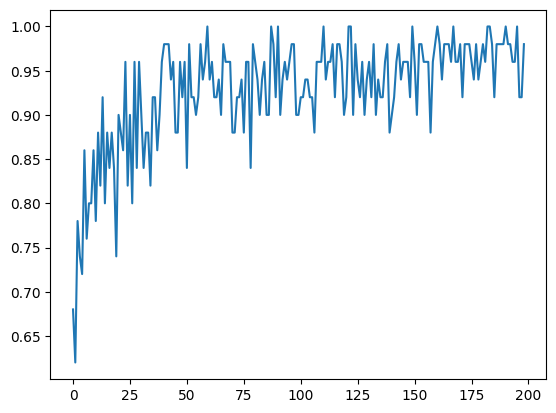

In [313]:
plt.plot(winrate_history)

In [315]:
# average of the last 10 winrates (last 500 games)
round(sum(winrate_history[-10:]) / len(winrate_history[-10:]), 2)

0.97

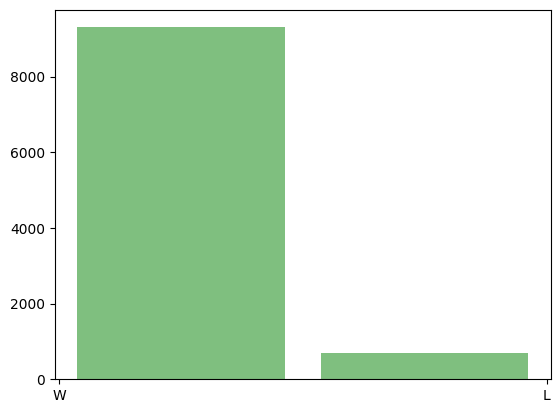

In [299]:
plt.hist(history, bins=2, color= ['green'], alpha=0.5, rwidth=0.85)
plt.show()

Min-Sum (Optimal) Player

In [293]:
def possible_actions( state, k = None):
        '''returns a list of possible actions for a given state'''
        
        listo = []
        if k == None:
            # if k is not defined, then the player can remove any number of objects from any row
            
            for row, objects in enumerate(state):            
                for remaining in range(objects):
                    listo.append((row,objects - remaining))
            return listo
        else:
            # if k is defined, then the player can remove any number of objects up to k from any row
            for row, objects in enumerate(state):            
                for remain in range(objects):
                    if objects - remain <= k:
                        listo.append((row, objects - remain))
            return listo

In [301]:
losses = 0
wins = 0
history = []
winrate_history = []
epochs = 10000

for i in np.arange(epochs):
    currState = Nim(4, None)
    Q_learner = QLearner(currState)  

    while True:
        # Optimal player
        # in this case i needed to put is as first, since as second it would be impossible to beat
        brute_force = list()
        for m in possible_actions(currState._rows):
            tmp = deepcopy(currState)
            tmp.nimming2(m)
            brute_force.append((m, nim_sum(tmp)))
        move = min(brute_force, key=lambda x: x[1])[0]
        logging.debug(f"row: {move[0]} num_objects: {move[1]}")
        currState.nimming(move[0], move[1]) 
        logging.debug(f"currState: {currState._rows}")

        
        action_p1 = Q_learner.update_q(currState._rows, None) 
        logging.debug(f"action_p1: {action_p1}")

        if(action_p1 is not None):
            currState.nimming(action_p1[0], action_p1[1])
            logging.debug(f"currState: {currState._rows}") 

        if action_p1 is None:
            losses += 1
            history.append("L")
            logging.debug(f"Losses + 1")
            break
        elif currState.is_terminal():
            wins += 1
            history.append("W")
            logging.debug(f"Wins + 1")
            break         
        
    
    if (i != 0) and (i % 50 == 0):
        s50 = history[-50:]
        wi = len([s for s in s50 if s == "W"])
        lo = 50 - wi
        winrate_history.append(wi/(wi+lo))
        #logging.info(f"i: {i} wins: {wins} losses: {losses} winrate: {wins/(wins+losses)} winrate history (last 50s): {wi/(wi+lo)}")

print(f"matches: {epochs} wins: {wins} losses: {losses} winrate: {wins/(wins+losses)}")



matches: 10000 wins: 9258 losses: 742 winrate: 0.9258


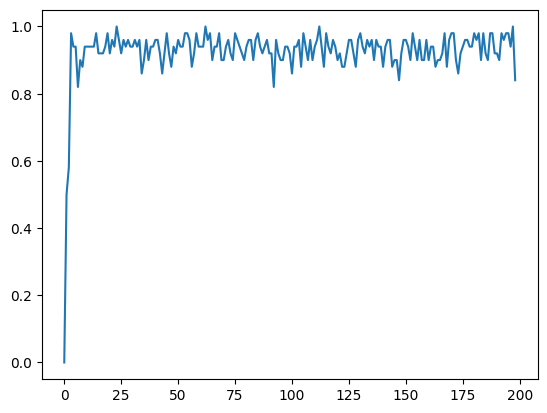

In [302]:
plt.plot(winrate_history)

In [316]:
# average of the last 10 winrates (last 500 games)
round(sum(winrate_history[-10:]) / len(winrate_history[-10:]),2)

0.97